Import packages

In [11]:
import os
import numpy as np
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab import imshow_grid_at_node
from landlab.components import ChannelProfiler, FlowAccumulator
import matplotlib.pyplot as mp

Load DEM

In [2]:
fname = os.path.join(r'dem_30m.asc')
mg, z = read_esri_ascii(fname, name='topographic__elevation')

close no-data vals

In [5]:
nodata = -9999.
mg.status_at_node[np.isclose(z, nodata)] = mg.BC_NODE_IS_CLOSED

find possible watershed outlet nodes

In [6]:
mg.set_watershed_boundary_condition('topographic__elevation', nodata, True)

ValueError: Grid has two potential outlet nodes.They have the following node IDs: 
[408536 411983 411984 411985 411986]
Use the method set_watershed_boundary_condition_outlet_id to explicitly select one of these IDs as the outlet node.

use first selected node from ValueError list above as our outlet node:

In [7]:
mg.status_at_node[408536] = mg.BC_NODE_IS_FIXED_VALUE #this makes the flow accumulator run a ton faster!

Run flow accumulator

In [8]:
fa = FlowAccumulator(mg, 
                     'topographic__elevation',
                     flow_director='D8',
                     depression_finder='DepressionFinderAndRouter')
fa.run_one_step()

Check location of outlet nodes to make sure th

In [17]:
pot_outlets = [408536, 411983, 411984, 411985, 411986]

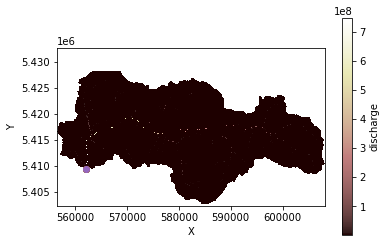

In [18]:
f, ax = mp.subplots()
imshow_grid_at_node(mg,
                    mg.at_node['surface_water__discharge'],
                    colorbar_label='discharge',
                    color_for_closed=None)
for node in pot_outlets:
    ax.scatter(mg.x_of_node[node], mg.y_of_node[node])